In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from yellowbrick.model_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE, Isomap
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from imblearn.under_sampling import NearMiss
from sklearn.tree import DecisionTreeClassifier

In [72]:
dfr = pd.read_csv(r"energy_task.csv")
dfr=dfr.drop(columns =['date'])
dfr = dfr.dropna()

#dfres= pd.read_csv(r"energy_task.csv")
#dfres=dfres.drop(columns =['date'])
dfres = dfr

In [73]:
dfc = pd.read_csv(r"classification.csv")
df_0 = dfc[dfc["hazardous"] == 0]
df_1 = dfc[dfc["hazardous"] == 1]
df_1_cut = df_1.sample(len(df_0), replace=True)


dfc = pd.concat([df_1_cut, df_0], axis=0)
dfc = shuffle(dfc)


In [74]:
y_class = dfc["hazardous"]
X_class = dfc.drop("hazardous", axis=1)
y_reg = dfr["Appliances"]
X_reg = dfr.drop("Appliances", axis=1)

y_res = dfres["Appliances"]
X_res = dfres.drop("Appliances", axis=1)


In [75]:
from sklearn.ensemble import GradientBoostingRegressor

def test_reg(X,y):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    bag = GradientBoostingRegressor().fit(x_train, y_train)
    print(f'R^2: {bag.score(x_test, y_test)}')

In [76]:
from sklearn.ensemble import BaggingClassifier
def test_class(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    bag = BaggingClassifier().fit(X_train, y_train)
    print(confusion_matrix(y_test, bag.predict(X_test)))
    print(classification_report(y_test, bag.predict(X_test)))


In [77]:
test_reg(X_reg, y_reg)

R^2: 0.2608682833169076


In [78]:
test_class(X_class,y_class)

[[24572  1875]
 [   21 26296]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     26447
           1       0.93      1.00      0.97     26317

    accuracy                           0.96     52764
   macro avg       0.97      0.96      0.96     52764
weighted avg       0.97      0.96      0.96     52764



# Variance Treshold (признаки с высокой дисперсией)

### Regression

In [79]:
X_reg.describe()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
count,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000,...,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000,18642.000000
mean,3.782319,21.691266,40.254617,20.345622,40.415268,22.274641,39.235791,20.861398,39.022534,19.598765,...,22.035623,42.927422,19.493501,41.551542,7.418547,755.507530,79.750294,4.037148,38.312982,3.767238
std,7.921103,1.610110,3.978440,2.196002,4.071280,2.011074,3.251101,2.046602,4.339207,1.850718,...,1.959176,5.223269,2.019902,4.150176,5.318784,7.412288,14.900838,2.444946,11.777532,4.200019
min,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,...,16.362222,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.550000
25%,0.000000,20.730000,37.333333,18.823333,37.886250,20.790000,36.900000,19.533333,35.519125,18.290000,...,20.790000,39.064167,18.000000,38.518000,3.670000,750.900000,70.166667,2.000000,29.000000,0.900000
50%,0.000000,21.600000,39.638745,20.000000,40.500000,22.100000,38.533000,20.666667,38.400000,19.390000,...,22.127778,42.363333,19.390000,40.900000,6.920000,756.100000,83.666667,3.666667,40.000000,3.430000
75%,0.000000,22.600000,43.060000,21.500000,43.260000,23.323333,41.760000,22.100000,42.153750,20.633333,...,23.390000,46.529722,20.600000,44.326667,10.400000,760.933333,91.666667,5.500000,40.000000,6.580000
max,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,...,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000


In [80]:
vt = VarianceThreshold(4)
X_vt = vt.fit_transform(X_reg)

print(X_reg.shape)
print(X_vt.shape)

X_vt = pd.DataFrame(X_vt, columns=vt.get_feature_names_out())
test_reg(X_vt, y_reg)

(18642, 25)
(18642, 22)
R^2: 0.2479901057611743


In [81]:
diff_columns  = set(X_reg.columns) - set(X_vt.columns)

print("Удаленные столбцы после снижения размерности:")
for col in diff_columns:
    print(col)

Удаленные столбцы после снижения размерности:
T1
T5
T8


### Classification

In [82]:
X_class.describe()

,Unnamed: 0,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,159888.000000,159888.000000,159888.000000,159888.000000,1.598880e+05,159888.000000
mean,45369.370822,0.202318,0.452398,54635.123268,3.829523e+07,22.088636
std,26235.480904,0.311103,0.695648,27102.556772,2.185882e+07,2.831107
min,0.000000,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,22619.750000,0.040230,0.089958,34043.348052,1.923030e+07,20.200000
50%,45428.500000,0.134448,0.300635,50777.366461,3.920689e+07,21.480000
75%,68023.000000,0.242412,0.542051,70415.472549,5.741132e+07,24.100000
max,90835.000000,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [83]:
vt = VarianceThreshold(2)
X_vt = vt.fit_transform(X_class)

print(X_class.shape)
print(X_vt.shape)

X_vt = pd.DataFrame(X_vt, columns=vt.get_feature_names_out())
test_class(X_vt, y_class)

(159888, 6)
(159888, 4)
[[24455  1898]
 [   36 26375]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     26353
           1       0.93      1.00      0.96     26411

    accuracy                           0.96     52764
   macro avg       0.97      0.96      0.96     52764
weighted avg       0.97      0.96      0.96     52764



In [84]:
diff_columns  = set(X_class.columns) - set(X_vt.columns)

print("Удаленные столбцы после снижения размерности:")
for col in diff_columns:
    print(col)

Удаленные столбцы после снижения размерности:
est_diameter_min
est_diameter_max


# SelectKBest (Одномерный отбор признаков)
### Regression

C:\Users\dimka\AppData\Local\Temp\ipykernel_632\2647280677.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  new_df = dfr[correct]


Text(0.5, 1.0, 'Тепловая карта')

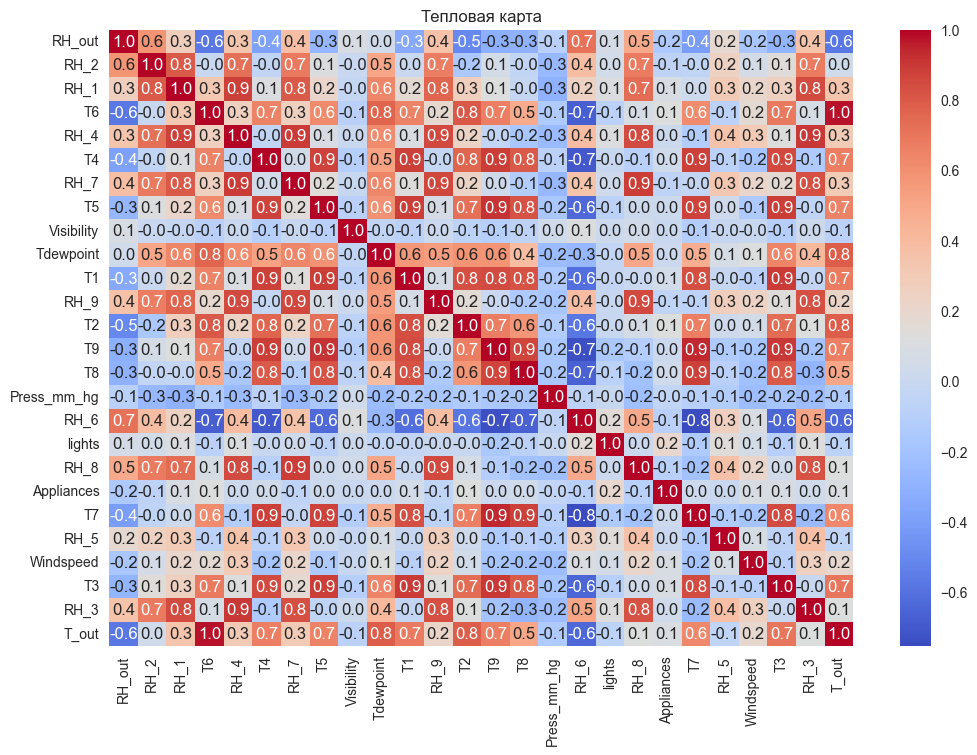

In [85]:
correct = set(dfr.columns)
new_df = dfr[correct]
plt.figure(figsize=(12, 8))
sns.heatmap(new_df.corr(), annot=True, cmap='coolwarm',fmt=".1f")
plt.title('Тепловая карта')

In [86]:
skb = SelectKBest(k=25)
X_skb = skb.fit_transform(X_reg, y_reg)

print(X_reg.shape)
print(X_skb.shape)

X_skb = pd.DataFrame(X_skb, columns=skb.get_feature_names_out())
test_reg(X_skb, y_res)

(18642, 25)
(18642, 25)
R^2: 0.2632133694731795


In [87]:
diff_columns  = set(X_reg.columns) - set(X_skb.columns)

print("Удаленные столбцы после снижения размерности:")
for col in diff_columns:
    print(col)

Удаленные столбцы после снижения размерности:


### Classification

C:\Users\dimka\AppData\Local\Temp\ipykernel_632\854487758.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  new_df = dfc[correct]


Text(0.5, 1.0, 'Тепловая карта')

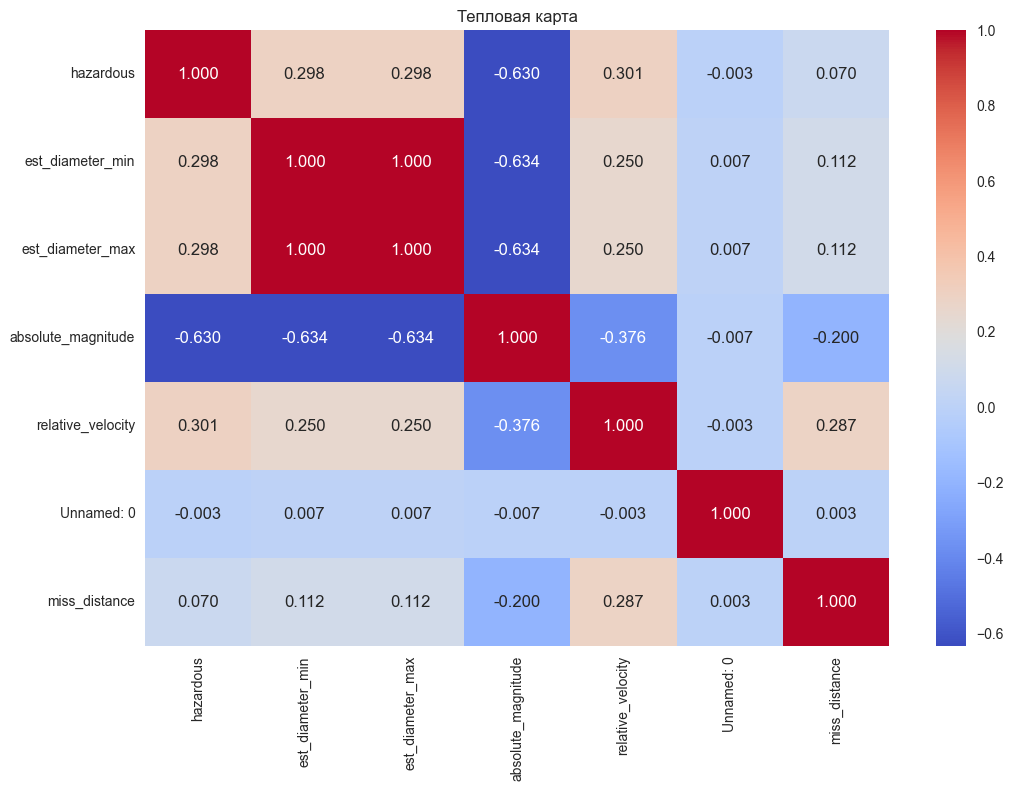

In [88]:
correct = set(dfc.columns)
new_df = dfc[correct]
plt.figure(figsize=(12, 8))
sns.heatmap(new_df.corr(), annot=True, cmap='coolwarm',fmt=".3f")
plt.title('Тепловая карта')

In [89]:
skb = SelectKBest(k=5)
X_skb = skb.fit_transform(X_class, y_class)

print(X_class.shape)
print(X_skb.shape)

X_skb = pd.DataFrame(X_skb, columns=skb.get_feature_names_out())
test_class(X_skb, y_class)

(159888, 6)
(159888, 5)
[[24421  1968]
 [   30 26345]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     26389
           1       0.93      1.00      0.96     26375

    accuracy                           0.96     52764
   macro avg       0.96      0.96      0.96     52764
weighted avg       0.96      0.96      0.96     52764



In [90]:
diff_columns  = set(X_class.columns) - set(X_vt.columns)

print("Удаленные столбцы после снижения размерности:")
for col in diff_columns:
    print(col)

Удаленные столбцы после снижения размерности:
est_diameter_min
est_diameter_max


## RFE (екурсивный отбор признаков)
### Regression

In [115]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=LinearRegression())
tree = DecisionTreeClassifier().fit(X_res, y_res)

rfe = RFE(estimator=tree).fit(X_res, y_res)
X_rfe = pd.DataFrame(rfe.transform(X_res), columns=rfe.get_feature_names_out())

print(X_res.shape)
print(X_rfe.shape)

test_reg(X_rfe, y_res)

(8000, 25)
(8000, 12)
R^2: 0.2996061181469899


In [116]:
diff_columns  = set(X_res.columns) - set(X_rfe.columns)

print("Удаленные столбцы после снижения размерности:")
for col in diff_columns:
    print(col)

Удаленные столбцы после снижения размерности:
RH_out
RH_4
T4
T7
T5
Visibility
Windspeed
T1
lights
RH_2
T3
T2
T9


### Classification

In [117]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(X_class, y_class)

rfe = RFE(estimator=tree).fit(X_class, y_class)
X_rfe = pd.DataFrame(rfe.transform(X_class), columns=rfe.get_feature_names_out())

print(X_class.shape)
print(X_rfe.shape)

test_class(X_rfe, y_class)

(9000, 6)
(9000, 3)
[[1205  297]
 [ 131 1337]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1502
           1       0.82      0.91      0.86      1468

    accuracy                           0.86      2970
   macro avg       0.86      0.86      0.86      2970
weighted avg       0.86      0.86      0.86      2970



In [118]:
diff_columns  = set(X_class.columns) - set(X_rfe.columns)

print("Удаленные столбцы после снижения размерности:")
for col in diff_columns:
    print(col)

Удаленные столбцы после снижения размерности:
Unnamed: 0
est_diameter_max
absolute_magnitude


# PCA (Метод главных компонент)
### Regression

In [95]:

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_res, y_res)

print(X_res.shape)
print(X_pca.shape)

test_reg(X_pca, y_res)


(18642, 25)
(18642, 4)
R^2: 0.08916967476131465


In [96]:
X_pca

array([[-36.67408083,   5.42075677, -26.48938034,   9.4972784 ],
       [-36.35884712,   6.67128876, -22.88105746,   9.17250208],
       [-35.38312645,   7.86216252, -19.28493797,   8.58537738],
       ...,
       [ 59.41000452,  28.45227036,  -0.67234666,  10.13926973],
       [ 59.08430411,  27.80190683,  -1.2800692 ,   9.67802579],
       [ 58.75587692,  27.05723741,  -1.85379329,   9.2395967 ]])

In [97]:
used_columns = []
for i in range(len(pca.components_)):
    used_cols = X_res.columns[pca.components_[i] != 0].tolist()
    used_columns.extend(used_cols)

# Удаление дубликатов
used_columns = list(set(used_columns))

print("Столбцы, использованные для создания нового датасета с PCA:")
print(used_columns)
print(len(used_columns))

Столбцы, использованные для создания нового датасета с PCA:
['RH_out', 'RH_2', 'RH_1', 'T6', 'RH_4', 'T4', 'RH_7', 'T5', 'Visibility', 'Tdewpoint', 'T1', 'RH_9', 'T2', 'T9', 'T8', 'Press_mm_hg', 'RH_6', 'lights', 'RH_8', 'T7', 'RH_5', 'Windspeed', 'T3', 'RH_3', 'T_out']
25


### Classification

In [98]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_class, y_class)

print(X_class.shape)
print(X_pca.shape)

test_class(X_pca, y_class)


(159888, 6)
(159888, 2)
[[23871  2418]
 [   96 26379]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     26289
           1       0.92      1.00      0.95     26475

    accuracy                           0.95     52764
   macro avg       0.96      0.95      0.95     52764
weighted avg       0.96      0.95      0.95     52764



In [99]:
used_columns = []
for i in range(len(pca.components_)):
    used_cols = X_class.columns[pca.components_[i] != 0].tolist()
    used_columns.extend(used_cols)

# Удаление дубликатов
used_columns = list(set(used_columns))

print("Столбцы, использованные для создания нового датасета с PCA:")
print(used_columns)
print(len(used_columns))

Столбцы, использованные для создания нового датасета с PCA:
['est_diameter_min', 'est_diameter_max', 'absolute_magnitude', 'relative_velocity', 'Unnamed: 0', 'miss_distance']
6


# TSNE (Нелинейные методы выделения признаков)
### Regression

In [100]:
tsne = TSNE()
X_tsner = tsne.fit_transform(X_res)

print(X_res.shape)
print(X_tsner.shape)

test_reg(X_tsner, y_res)

(18642, 25)
(18642, 2)
R^2: 0.1022779562813908


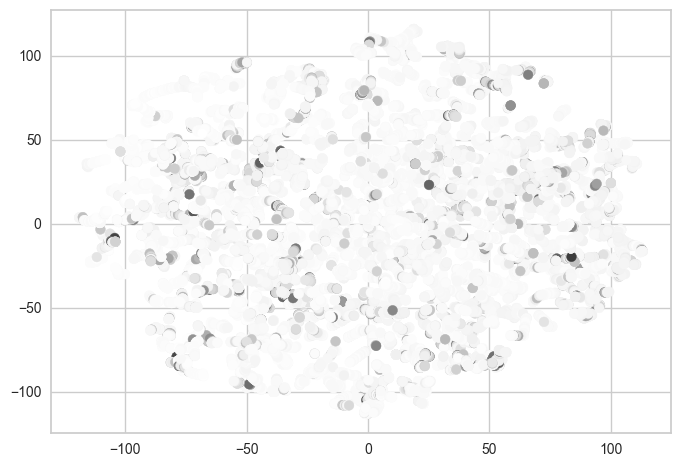

In [101]:
plt.scatter(X_tsner[:,0], X_tsner[:,1], c=y_res)


### Classification

In [102]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_class)

print(X_class.shape)
print(X_tsne.shape)

test_class(X_tsne, y_class)

(159888, 6)
(159888, 2)
[[22899  3371]
 [  132 26362]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     26270
           1       0.89      1.00      0.94     26494

    accuracy                           0.93     52764
   macro avg       0.94      0.93      0.93     52764
weighted avg       0.94      0.93      0.93     52764



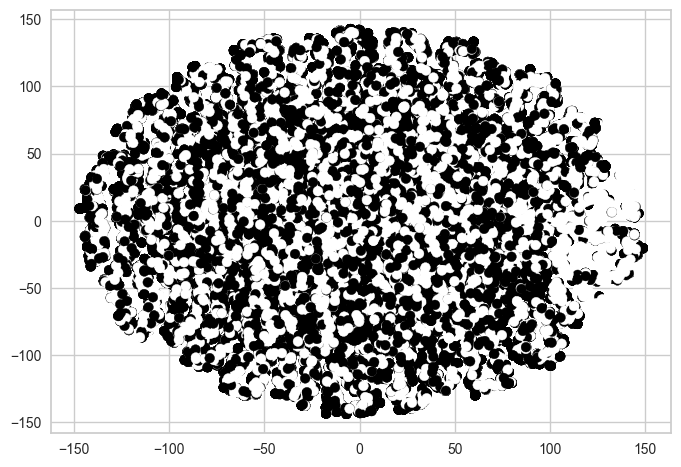

In [103]:
import matplotlib.pyplot as plt
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_class)

# Isomap
### Regression

In [104]:
# MemoryError: Unable to allocate 6.43 GiB for an array with shape (29378, 29378) and data type float64

X_res=X_res[:8000]
y_res=y_res[:8000]

In [105]:
from sklearn.manifold import Isomap
isomap = Isomap()
X_iso = isomap.fit_transform(X_res)

print(X_res.shape)
print(X_iso.shape)

test_reg(X_iso, y_res)

C:\Osnova\Programming\Python\ML\test\venv\Lib\site-packages\sklearn\manifold\_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Osnova\Programming\Python\ML\test\venv\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Osnova\Programming\Python\ML\test\venv\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Osnova\Programming\Python\ML\test\venv\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


(8000, 25)
(8000, 2)
R^2: 0.08812952190158596


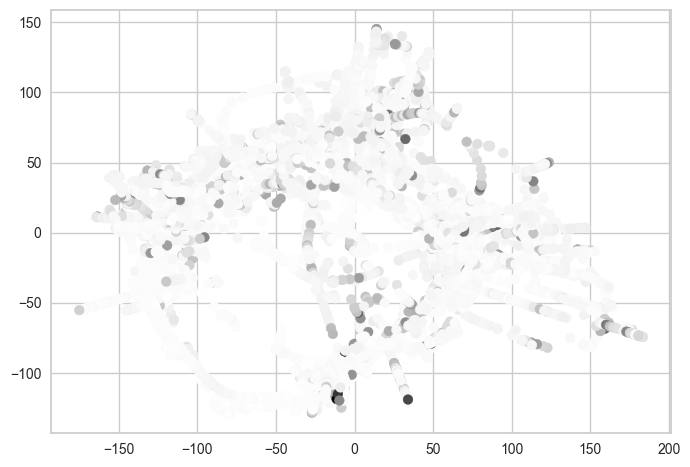

In [107]:
plt.scatter(X_iso[:,0], X_iso[:,1], c=y_res)


### Classification

In [112]:
X_class=X_class[:9000]
y_class=y_class[:9000]


In [113]:
isomap = Isomap(n_components=2)
X_iso = isomap.fit_transform(X_class)

print(X_class.shape)
print(X_iso.shape)

test_class(X_iso, y_class)

C:\Osnova\Programming\Python\ML\test\venv\Lib\site-packages\sklearn\manifold\_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 27 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Osnova\Programming\Python\ML\test\venv\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Osnova\Programming\Python\ML\test\venv\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Osnova\Programming\Python\ML\test\venv\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

(9000, 6)
(9000, 2)
[[911 585]
 [633 841]]
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      1496
           1       0.59      0.57      0.58      1474

    accuracy                           0.59      2970
   macro avg       0.59      0.59      0.59      2970
weighted avg       0.59      0.59      0.59      2970



C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\djego\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficie

(9000, 15)
(9000, 2)
[[1532    2]
 [   9 1427]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1534
           1       1.00      0.99      1.00      1436

    accuracy                           1.00      2970
   macro avg       1.00      1.00      1.00      2970
weighted avg       1.00      1.00      1.00      2970



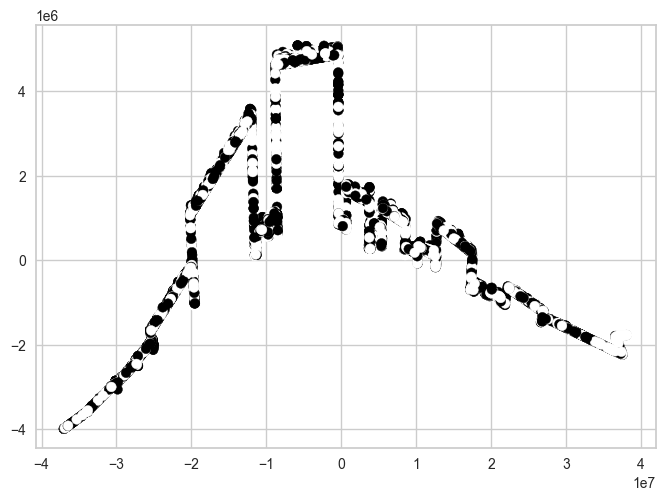

In [114]:
plt.scatter(X_iso[:,0], X_iso[:,1], c=y_class)


Вывод:

Variance Treshold :
* хорошо подходит для регрессии -3 признак
* хорошо для классификации -2 признака

SelectKBest
* не изменил размерность регрессии
* хорошо для классификации -1
  
RFE
* до 12 признаков -13 с не больим увеличением точности
* -3 признака с базовой точностью

PCA
* до 4 признаков, большие потери
* до 2 с базовой точностью
  
TSNE
* до 2 с потрей
*  до 2 с боазовой точностью
  
Isomap
* до 2 спотерей
* до 2 с потрей

Тем самым

для ререссии лучшее RFE с уменьшением признаков в 2 раза и чутть повышиной точностью

для классификации PCA и TSNE приводящие к 2 признакам без изменения точности